In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv("updated.csv", low_memory=False)
df.head()

,Age (days),#ofPosts,Posts/Day,OddsBeingBot
0,4256,23279,5.469690,0.020441
1,4124,525,0.127304,0.073133
2,4313,8146,1.888709,0.041325
3,4226,3510,0.830573,0.014311
4,4351,8146,1.872213,0.058340


In [2]:
df.dtypes

Age (days)        int64
#ofPosts          int64
Posts/Day       float64
OddsBeingBot    float64
dtype: object

## Viz

### Quick heatmap for correlation

<AxesSubplot:>

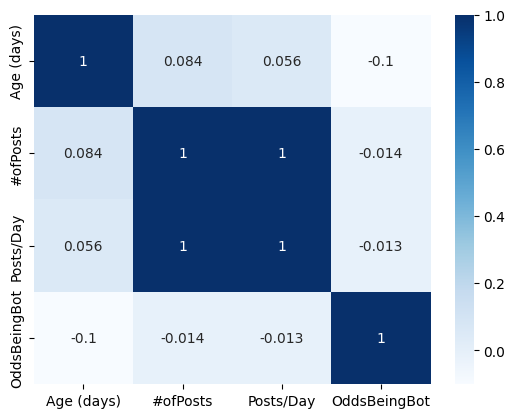

In [3]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot=True)

#### Lots of weak correlations, time to model

## Modeling

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.tree import DecisionTreeRegressor

### Mean avg, squared, and r squared scores function

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def eval(y_true, y_pred):  
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f'scores: \nMAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.2f}')

### Train Test Split

In [6]:
X = df.drop(columns=['OddsBeingBot'])
y = df['OddsBeingBot']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler()

### Decision Tree

In [7]:
dec_tree = DecisionTreeRegressor(random_state = 42)
dec_pipe = make_pipeline(scaler, dec_tree)
dec_pipe.fit(X_train, y_train)
print('Train')
eval(y_train, dec_pipe.predict(X_train))
print('Test')
eval(y_test, dec_pipe.predict(X_test))

Train
scores: 
MAE: 0.00 
MSE: 0.00 
RMSE: 0.01 
R2: 1.00
Test
scores: 
MAE: 0.23 
MSE: 0.11 
RMSE: 0.34 
R2: -0.98


### Tuning, these are bad scores

In [8]:
dec_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('decisiontreeregressor', DecisionTreeRegressor(random_state=42))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'decisiontreeregressor': DecisionTreeRegressor(random_state=42),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'decisiontreeregressor__ccp_alpha': 0.0,
 'decisiontreeregressor__criterion': 'squared_error',
 'decisiontreeregressor__max_depth': None,
 'decisiontreeregressor__max_features': None,
 'decisiontreeregressor__max_leaf_nodes': None,
 'decisiontreeregressor__min_impurity_decrease': 0.0,
 'decisiontreeregressor__min_samples_leaf': 1,
 'decisiontreeregressor__min_samples_split': 2,
 'decisiontreeregressor__min_weight_fraction_leaf': 0.0,
 'decisiontreeregressor__random_state': 42,
 'decisiontreeregressor__splitter': 'best'}

#### We'll be tuning with max_leaf_nodes, min_samples_leaf, and max_depth

,Test Score,Train Score
2,0.02287,0.01479
3,0.022331,0.019117
4,0.018811,0.024236
5,0.00338,0.037458
6,-0.020891,0.055673


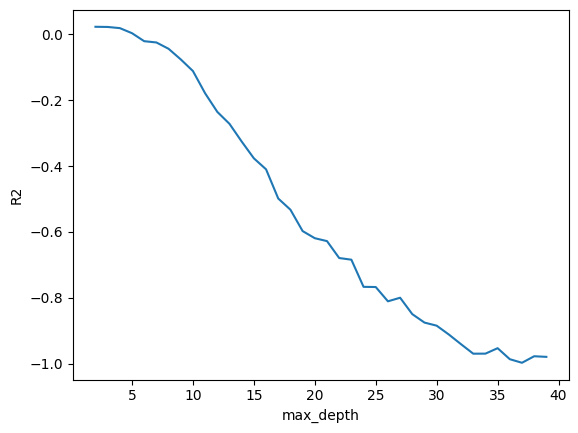

In [9]:
depths = list(range(2, 40))
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train, y_train)
    train_score = dec_tree.score(X_train, y_train)
    test_score = dec_tree.score(X_test, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

2 is the best depth

In [10]:
dec_tree_fin = DecisionTreeRegressor(max_depth = 2, random_state = 42)
dec_tree_fin.fit(X_train, y_train)
print('Training')
eval(y_train, dec_tree_fin.predict(X_train))
print('Testing')
eval(y_test, dec_tree_fin.predict(X_test))

Training
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.01
Testing
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.02


,Test Score,Train Score
2,0.02287,0.01479
30,0.02287,0.01479
23,0.02287,0.01479
24,0.02287,0.01479
25,0.02287,0.01479


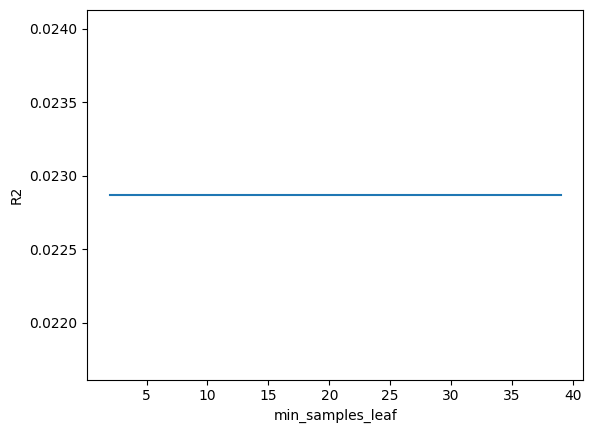

In [11]:
samples = list(range(2, 40))
scores2 = pd.DataFrame(index=samples, columns=['Test Score','Train Score'])
for sample in samples:
    dec_tree_fin = DecisionTreeRegressor(min_samples_leaf=sample, max_depth = 2, random_state=42)
    dec_tree_fin.fit(X_train, y_train)
    train_score = dec_tree_fin.score(X_train, y_train)
    test_score = dec_tree_fin.score(X_test, y_test)
    scores2.loc[sample, 'Train Score'] = train_score
    scores2.loc[sample, 'Test Score'] = test_score
plt.plot(samples, scores2['Test Score'])
plt.xlabel('min_samples_leaf')
plt.ylabel('R2');
sorted_scores2 = scores2.sort_values(by='Test Score', ascending=False)
sorted_scores2.head()

All the same

,Test Score,Train Score
21,0.02287,0.01479
22,0.02287,0.01479
24,0.02287,0.01479
25,0.02287,0.01479
26,0.02287,0.01479


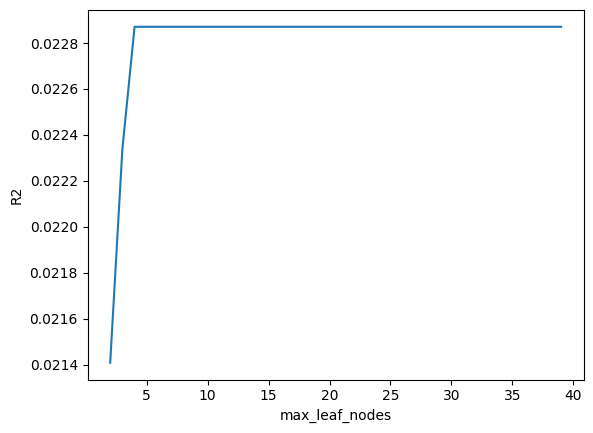

In [12]:
leaves = list(range(2, 40))
scores3 = pd.DataFrame(index=leaves, columns=['Test Score','Train Score'])
for leaf in leaves:
    dec_tree_fin = DecisionTreeRegressor(max_leaf_nodes=leaf, max_depth = 2, random_state=42)
    dec_tree_fin.fit(X_train, y_train)
    train_score = dec_tree_fin.score(X_train, y_train)
    test_score = dec_tree_fin.score(X_test, y_test)
    scores3.loc[leaf, 'Train Score'] = train_score
    scores3.loc[leaf, 'Test Score'] = test_score
plt.plot(leaves, scores3['Test Score'])
plt.xlabel('max_leaf_nodes')
plt.ylabel('R2');
sorted_scores3 = scores3.sort_values(by='Test Score', ascending=False)
sorted_scores3.head()

Anything above 5 is the same

In [13]:
dec_tree_fin = DecisionTreeRegressor(max_leaf_nodes = 26, max_depth = 2, random_state = 42)
dec_tree_fin.fit(X_train, y_train)
print('Train')
eval(y_train, dec_tree_fin.predict(X_train))
print('Test')
eval(y_test, dec_tree_fin.predict(X_test))

Train
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.01
Test
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.02


### Going to do a grid search to see if that gives us better results

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
model1 = DecisionTreeRegressor(random_state=42)
param_grid1 = {'max_leaf_nodes': [5,10,15,20,25,30,35,40],
               'min_samples_leaf': [5,10,15,20,25,30,35,40]}
grid_search1 = GridSearchCV(model1, param_grid1)
grid_search1.fit(X_train, y_train)
grid_search1.best_params_

{'max_leaf_nodes': 5, 'min_samples_leaf': 40}

In [16]:
dec_tree_grid = DecisionTreeRegressor(max_leaf_nodes = 5, min_samples_leaf = 40, random_state = 42)
dec_tree_grid.fit(X_train, y_train)
print('Train')
eval(y_train, dec_tree_grid.predict(X_train))
print('Test')
eval(y_test, dec_tree_grid.predict(X_test))

Train
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.02
Test
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: 0.02


## This model is really weak, have to try some other things.  Maybe neural net, but first try bagging regressor or random forest

In [17]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [18]:
bagreg = BaggingRegressor(random_state = 42)

In [19]:
bagreg = DecisionTreeRegressor(random_state = 42)
bag_pipe = make_pipeline(scaler, bagreg)
bag_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [33]:
bagreg_train_score = bagreg.score(X_train, y_train)
bagreg_test_score = bagreg.score(X_test, y_test)
print('Train')
eval(y_train, bagreg.predict(X_train))
print('Test')
eval(y_test, bagreg.predict(X_test))

Train
scores: 
MAE: 0.08 
MSE: 0.01 
RMSE: 0.11 
R2: 0.78
Test
scores: 
MAE: 0.19 
MSE: 0.07 
RMSE: 0.26 
R2: -0.22


As expected this model is similarly weak, but we can practice tuning.

In [26]:
bagreg.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

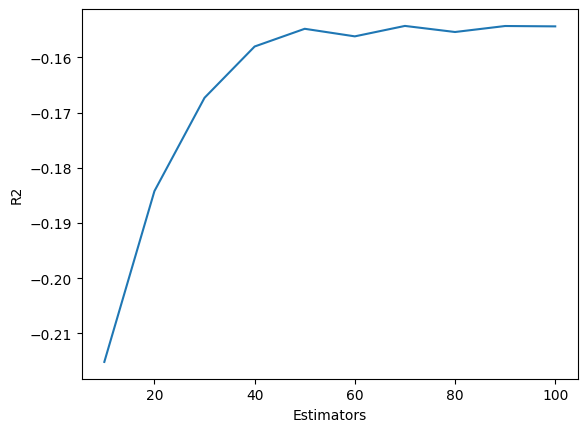

,Train Score,Test Score
70,0.829001,-0.154283
90,0.83159,-0.154299
100,0.831845,-0.154364
50,0.826103,-0.154803
80,0.829908,-0.155385
60,0.827562,-0.156174
40,0.822853,-0.158012
30,0.818332,-0.167307
20,0.808492,-0.184218
10,0.77878,-0.215169


In [28]:
estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bag_scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
for num_estimators in estimators:
   bag_reg = BaggingRegressor(n_estimators=num_estimators, random_state=42)
   bag_reg.fit(X_train, y_train)
   bag_train_score = bag_reg.score(X_train, y_train)
   bag_test_score = bag_reg.score(X_test, y_test)
   bag_scores.loc[num_estimators, 'Train Score'] = bag_train_score
   bag_scores.loc[num_estimators, 'Test Score'] = bag_test_score

plt.xlabel('Estimators')
plt.ylabel('R2');
plt.plot(bag_scores['Test Score'])
plt.show()
bag_scores = bag_scores.sort_values(by='Test Score', ascending=False)
bag_scores

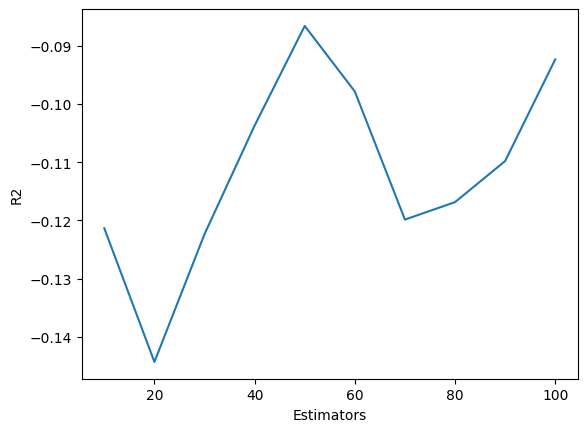

,Train Score,Test Score
50,-0.066002,-0.086618
100,-0.060012,-0.092365
60,-0.088227,-0.097867
40,-0.073199,-0.103721
90,-0.088458,-0.109811
80,-0.105107,-0.116862
70,-0.08796,-0.119859
10,-0.093099,-0.121362
30,-0.098298,-0.122356
20,-0.12071,-0.144288


In [38]:
samples = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bag_scores2 = pd.DataFrame(index=samples, columns=['Train Score', 'Test Score'])
for sample in samples:
   bag_reg_fin = BaggingRegressor(max_samples=sample, random_state=42)
   bag_reg_fin.fit(X_train, y_train)
   bag_train_score = bag_reg_fin.score(X_train, y_train)
   bag_test_score = bag_reg_fin.score(X_test, y_test)
   bag_scores2.loc[sample, 'Train Score'] = bag_train_score
   bag_scores2.loc[sample, 'Test Score'] = bag_test_score

plt.xlabel('Estimators')
plt.ylabel('R2');
plt.plot(bag_scores2['Test Score'])
plt.show()
bag_scores2 = bag_scores2.sort_values(by='Test Score', ascending=False)
bag_scores2

In [45]:
model2 = BaggingRegressor(random_state=42)
param_grid2 = {'n_estimators': [5,10,15,20,25,30,35,40],
              'max_samples': [5,10, 15, 25, 30, 35, 40]}
dt_grid_search2 = GridSearchCV(model2, param_grid2)
dt_grid_search2.fit(X_train, y_train)
dt_grid_search2.best_params_

{'max_samples': 30, 'n_estimators': 40}

In [37]:
bag_reg_fin = BaggingRegressor(max_samples=30, n_estimators=40, random_state=42)
bag_reg_fin.fit(X_train, y_train)
print('Train')
eval(y_train, bag_reg_fin.predict(X_train))
print('Test')
eval(y_test, bag_reg_fin.predict(X_test))

Train
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: -0.00
Test
scores: 
MAE: 0.18 
MSE: 0.06 
RMSE: 0.24 
R2: -0.00


Can't fix tuning this, but exercise done.

## Random Forest Model

In [46]:
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Base model accuracy

In [48]:
print('Train')
eval(y_train, rf.predict(X_train))
print('Test')
eval(y_test, rf.predict(X_test))

Train
scores: 
MAE: 0.07 
MSE: 0.01 
RMSE: 0.10 
R2: 0.83
Test
scores: 
MAE: 0.19 
MSE: 0.07 
RMSE: 0.26 
R2: -0.16


Base model is still pretty weak, hopefully we can better tune this to replicate the data's results

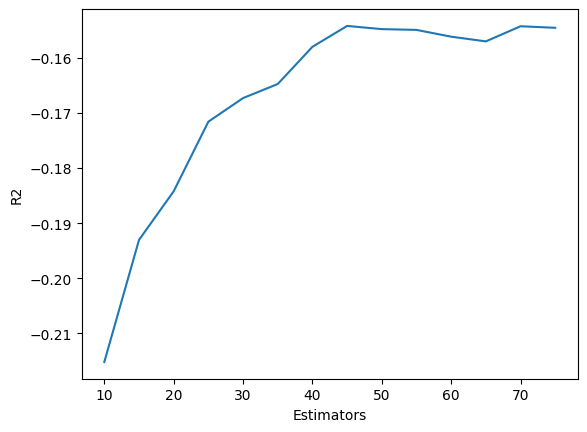

,Train Score,Test Score
45,0.824964,-0.154222
70,0.829001,-0.154283
75,0.829523,-0.154563
50,0.826103,-0.154803
55,0.826923,-0.154945


In [50]:
estimators = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
bag_scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
for num_estimators in estimators:
   bag_reg = BaggingRegressor(n_estimators=num_estimators, random_state=42)
   bag_reg.fit(X_train, y_train)
   bag_train_score = bag_reg.score(X_train, y_train)
   bag_test_score = bag_reg.score(X_test, y_test)
   bag_scores.loc[num_estimators, 'Train Score'] = bag_train_score
   bag_scores.loc[num_estimators, 'Test Score'] = bag_test_score

plt.xlabel('Estimators')
plt.ylabel('R2');
plt.plot(bag_scores['Test Score'])
plt.show()
bag_scores = bag_scores.sort_values(by='Test Score', ascending=False)
bag_scores.head()

,Test Score,Train Score
5,0.022252,0.046567
10,0.000324,0.204441
15,-0.043283,0.466631
20,-0.093014,0.66403
25,-0.125132,0.759289


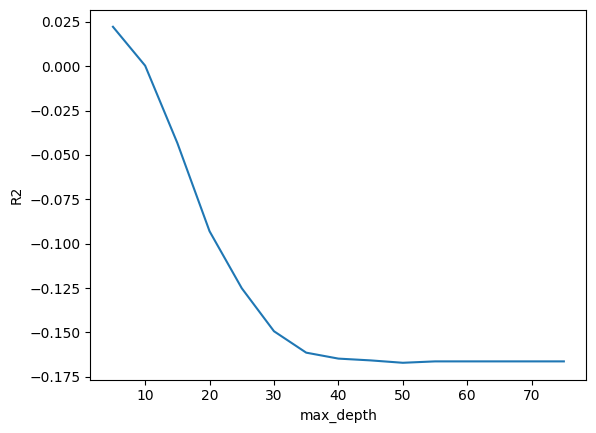

In [53]:
depths2 = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
bag_scores2 = pd.DataFrame(index=depths2, columns=['Test Score','Train Score'])
for depth2 in depths2:
    bagforest = RandomForestRegressor(max_depth=depth2, n_estimators=30, random_state=42)
    bagforest.fit(X_train, y_train)
    bagforest_train_score = bagforest.score(X_train, y_train)
    bagforest_test_score = bagforest.score(X_test, y_test)
    bag_scores2.loc[depth2, 'Train Score'] = bagforest_train_score
    bag_scores2.loc[depth2, 'Test Score'] = bagforest_test_score
plt.plot(depths2, bag_scores2['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');
bag_scores2 = bag_scores2.sort_values(by='Test Score', ascending=False)
bag_scores2.head()